# 北京 AQI（空气质量指数）预测 Beijing AQI prediction 



## 我们将用循环神经网络预测未来24小时之内的AQI空气质量指数. We are going to use a Recurrent Neural network to predict the AQI in the future up to 24 hours. 

### 如果在演示中你有任何问题可以随时提问. If you have specific questions durring this presentations feel free to ask at any time


# 第一步是导入所有重要的库. First steps are to import all of the important libraries
## 关于本项目，我们将需要处理数据和演示结果. For this project we are going to need to process data and display results
### 我们将用Numpy做数据处理. We will use Numpy for data processing
### 用matplotlib作图. matplotlib for graphing
## 我们将用Keras构建循环神经网络. For building our Recurrent Neural Network we will use Keras
### Keras是基于TensorFlow或theano的一个抽象. Keras is an abstraction on top of Tensor flow or theano
### 我用的是TensorFlow，因为对于循环神经网络而言表现更好，它们有一些实验层是theano所没有的。I use Tensor Flow becuase performance is usually better for RNNs and I they have a few experimental layers that are not avalible for theano

In [1]:
#数据处理Data processing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydot_ng
from __future__ import division

import time
import pylab as pl
from IPython import display

#Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import np_utils
from keras.utils import plot_model
import h5py

#skLearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# phased LSTM
from phased_lstm_keras.PhasedLSTM import PhasedLSTM as PLSTM

batch_size = 24

Using TensorFlow backend.


# 加载数据. Loading the data
我们需要做的首要事情是加载数据，该数据我们为了配合我们的神经网络做了一些先前处理。本课我们不会深入这些但是它是训练的重要组成部分。优化不好的数据会使得你的神经网络难以收敛于一个答案。
One of the first things we are going to do is load the data that we have previously engineered to play nice with out neural network. We won't go in to that this lesson but it is an important aspect of training. Poorly optimized data will make it hard for the your neural network to converage on an answer.

### 数据Data
* Year
* Month
* Day
* Time
* Tempeture
* Humidity
* Wind Speed
* Wine Direction
* Wind Prediciton
    * +6 hours (Speed and direction)
    * +12 hours (Speed and direction)
    
    
### 读入数据. Read in the Data
### 所有数据输入正则化为从0-1. Scale all of the data inputs from 0,1
#### 数据正则化对于训练而言是非常重要的 **Input more information here**


In [2]:
RANDOM_SEED = 42


data = pd.read_csv('E16_Data.csv')
print(data)
num_rows = data.shape[0]
dataSet = data.values
dataSet = data.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
dataSet = scaler.fit_transform(dataSet)

          0    4     5      6      8    9            10            11  \
0      2011   25 -10.0  43.85   7.78  0.0  9.848078e-01  1.736482e-01   
1      2011   31  -8.0  37.50   9.72  0.0  9.848078e-01  1.736482e-01   
2      2011   31  -6.0  35.03  11.66  0.0  9.848078e-01  1.736482e-01   
3      2011   31  -4.0  30.11  11.66  0.0  1.000000e+00 -2.449294e-16   
4      2011   31  -3.0  30.42   9.72  0.0  9.848078e-01 -1.736482e-01   
5      2011   31  -2.0  28.25   7.78  0.0  9.848078e-01 -1.736482e-01   
6      2011   31  -1.0  26.25   9.72  0.0  1.000000e+00 -2.449294e-16   
7      2011   31  -1.0  26.25   7.78  0.0  9.848078e-01 -1.736482e-01   
8      2011   31  -1.0  26.25   5.83  0.0  9.848078e-01 -1.736482e-01   
9      2011   31  -3.0  30.42   3.89  0.0  9.848078e-01  1.736482e-01   
10     2011   31  -3.0  30.42   5.83  0.0  9.396926e-01 -3.420201e-01   
11     2011   31  -5.0  32.46   5.83  0.0  9.848078e-01 -1.736482e-01   
12     2011   31  -7.0  37.82   5.83  0.0  9.396926

In [3]:
dataSet.shape

(53352, 23)

# 把数据分解为训练集和测试集. Breaking Data in to Training and Test

### 训练集与测试集的比例为9比1. Training and testing split is 90%

训练神经网络的一个重要部分是把数据分解为训练集和测试集。如下，我们把数据分为4个不同的集合，对应于当前AQI指数和未来的正确AQI指数。分别是0-5, 6-11, 12-17, 18-23 小时集. 这使得我们可以更容易地比较模型预测的准确度。

An important part of training neural networks is breaking up the data in to a training and test set. Below we break the data in to 4 different sets corresponding to the current AQI and the correct AQI in the future. There is 0-5, 6-11, 12-17, 18-23 hour sets. THis allows us to compare the accuracy of the model for prediction much more easily.

In [4]:
#把数据分解为训练集和测试集，训练集是数据的90%
trainDataSize =  int(len(dataSet) * .9)
testDataSize = len(dataSet) - trainDataSize
train, test = dataSet[0:trainDataSize,:], dataSet[trainDataSize:len(dataSet),:]

# 把数据分为输入与输出. Break data in to input and output
### 输入为当前AQI指数和气候信息. Input is current AQI and Weather Information
### 输出为下个24小时的AQI指数. Output is the next 24 hours of the AQI


In [5]:
#把数据列表转换为数据集矩阵
def createInOut24(dataSet):
    dataInput = []
    dataOut = []
    remainder = (len(dataSet)-25) % batch_size
    print(remainder)
    print(len(dataSet))
    count = 0
    for i in range((len(dataSet)-25)-remainder):
        count = count + 1
        a = [dataSet[i, 0], dataSet[i, 1], dataSet[i, 2], dataSet[i, 3],dataSet[i, 4] ,dataSet[i, 5] ,dataSet[i, 6] ,dataSet[i, 7] ,dataSet[i, 8] ,dataSet[i, 9], dataSet[i, 10], dataSet[i, 11], dataSet[i, 12], dataSet[i, 13], dataSet[i, 14], dataSet[i, 15], dataSet[i, 16], dataSet[i, 17], dataSet[i, 18], dataSet[i, 19], dataSet[i, 20], dataSet[i, 21], dataSet[i, 22]]
        dataInput.append(a)
        dataHour = []
#         if count == 20:
#             break
        for j in range(24):
            dataHour.append(dataSet[i+j,1])
    #         print(dataHour)
        dataOut.append(dataHour)
    return np.array(dataInput), np.array(dataOut)

In [7]:
# 修正为 X=t 以及 Y=t+1
look_back = 12
trainCurrent, trainFutureAQI = createInOut24(train)
testCurrent, testFutureAQI = createInOut24(test)
# trainCurrent, trainFutureAQI = createInOut24(train)
# testCurrent, testFutureAQI = createInOut24(test)
# print(trainCurrent, trainFutureAQI)
trainCurrent.shape
dataSet[1][1]

15
48016
7
5336


0.045589692765113973

In [8]:
print(trainFutureAQI.shape)
print(trainCurrent.shape)
print(testFutureAQI.shape)
print(testCurrent.shape)

(47976, 24)
(47976, 23)
(5304, 24)
(5304, 23)


# 数据修正为神经网络可用的列表. Data reshaping in to arrays that will work with out neural networks
我们必须修正数据，以致神经网络可以正确地注入数据并输出一些有用的结果. We must reshape our data so that the neural network can properly injest the data and output something useful

In [9]:
# 修正输入为 [samples, time steps, features]
trainCurrent = np.reshape(trainCurrent, (trainCurrent.shape[0], 1, trainCurrent.shape[1]))
testCurrent = np.reshape(testCurrent, (testCurrent.shape[0], 1, testCurrent.shape[1]))
# print(trainCurrent[812:824], trainFutureAQI[812:824])
# trainFutureAQI = np.reshape(trainFutureAQI, (trainFutureAQI.shape[0], 1, trainFutureAQI.shape[1]))
# testFutureAQI = np.reshape(testFutureAQI, (testFutureAQI.shape[0], 1, testFutureAQI.shape[1]))

In [10]:
trainCurrent.shape

(47976, 1, 23)

# 模型构造：单层. Model Construction: Single Layer

### 输入层. Input Layer
** 23 inputs **
### 隐藏层. Hidden Layer
** 200 LSTM Units, Not stateful **
### 输出层. Output Layer
** Dense 24 units**


### 模型拟合. Model fitting
**Adam Optimizer **
** 10 Epochs **
** Batch Size: 100**

In [11]:
# 创建 LSTM 网络
LSTMmodel1 = Sequential()
LSTMmodel1.add(LSTM(200, input_shape=(1, 23)))
LSTMmodel1.add(Dense(24))
LSTMmodel1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
history = LSTMmodel1.fit(trainCurrent, trainFutureAQI, epochs=10, batch_size=100, verbose=2)

Epoch 1/10
7s - loss: 0.0041 - mean_absolute_error: 0.0439 - acc: 0.1139
Epoch 2/10
6s - loss: 0.0031 - mean_absolute_error: 0.0372 - acc: 0.1428
Epoch 3/10
6s - loss: 0.0030 - mean_absolute_error: 0.0360 - acc: 0.1429
Epoch 4/10
5s - loss: 0.0029 - mean_absolute_error: 0.0352 - acc: 0.1462
Epoch 5/10
5s - loss: 0.0028 - mean_absolute_error: 0.0346 - acc: 0.1493
Epoch 6/10
6s - loss: 0.0028 - mean_absolute_error: 0.0343 - acc: 0.1508
Epoch 7/10
5s - loss: 0.0028 - mean_absolute_error: 0.0340 - acc: 0.1515
Epoch 8/10
5s - loss: 0.0027 - mean_absolute_error: 0.0338 - acc: 0.1525
Epoch 9/10
5s - loss: 0.0027 - mean_absolute_error: 0.0335 - acc: 0.1547
Epoch 10/10
5s - loss: 0.0027 - mean_absolute_error: 0.0335 - acc: 0.1542


In [12]:
scores = LSTMmodel1.evaluate(testCurrent, testFutureAQI, verbose=0)
print("%s: %.5f" % (LSTMmodel1.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (LSTMmodel1.metrics_names[1], scores[1]*1000))
print("%s: %.2f%%" % (LSTMmodel1.metrics_names[2], scores[2]*100))
print(LSTMmodel1.summary())
LSTMmodel1.save("AQINet_lesson6_SingleLayer.h5")

loss: 0.00247
mean_absolute_error: 31.31%
acc: 15.37%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               179200    
_________________________________________________________________
dense_1 (Dense)              (None, 24)                4824      
Total params: 184,024.0
Trainable params: 184,024
Non-trainable params: 0.0
_________________________________________________________________
None


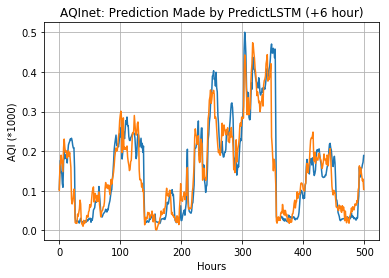

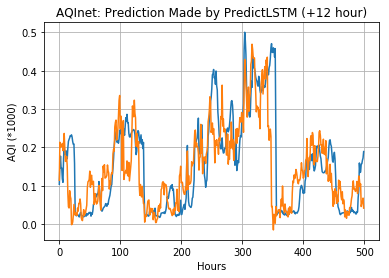

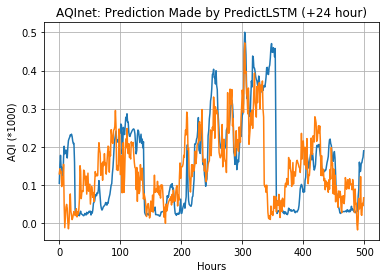

In [13]:
testPredictLSTM1 = LSTMmodel1.predict(testCurrent)
start = 4000
end = 4500

#6 hour
dataTrainTrunk = testPredictLSTM1[start:end,5]
dataSetAQI = []
for elem in dataSet:
    dataSetAQI.append(elem[1])
dataBeforeTrunk = dataSetAQI[trainDataSize+start:trainDataSize+end]


plt.title('AQInet: Prediction Made by PredictLSTM (+6 hour)')
# plt.legend(['A simple line'])
plt.plot(dataBeforeTrunk)
plt.plot(dataTrainTrunk)
plt.grid(True)
plt.ylabel('AQI (*1000)')
plt.xlabel('Hours')
plt.savefig('6hour_L6_1.png',dpi=1000)
plt.show()

#12 hour
dataTrainTrunk = testPredictLSTM1[start:end,11]
dataSetAQI = []
for elem in dataSet:
    dataSetAQI.append(elem[1])
dataBeforeTrunk = dataSetAQI[trainDataSize+start:trainDataSize+end]


plt.title('AQInet: Prediction Made by PredictLSTM (+12 hour)')
# plt.legend(['A simple line'])
plt.plot(dataBeforeTrunk)
plt.plot(dataTrainTrunk)
plt.grid(True)
plt.ylabel('AQI (*1000)')
plt.xlabel('Hours')
plt.savefig('12hour_L6_1.png',dpi=1000)
plt.show()


#24 hour

dataTrainTrunk = testPredictLSTM1[start:end,23]
dataSetAQI = []
for elem in dataSet:
    dataSetAQI.append(elem[1])
dataBeforeTrunk = dataSetAQI[trainDataSize+start:trainDataSize+end]


plt.title('AQInet: Prediction Made by PredictLSTM (+24 hour)')
# plt.legend(['A simple line'])
plt.plot(dataBeforeTrunk)
plt.plot(dataTrainTrunk)
plt.grid(True)
plt.ylabel('AQI (*1000)')
plt.xlabel('Hours')
plt.savefig('24hour_L6_1.png',dpi=1000)
plt.show()


# 模型构造：单层, 有状态. Model Construction: Single Layer, Stateful

### 输入层. Input Layer
** 23 inputs**
### 隐藏层. Hidden Layer
** 200 LSTM Units, Stateful, 24 hour window **
### 输出层. Output Layer
** Dense 24 units**


### 模型拟合. Model fitting
** Adam Optimizer **
** 10 Epochs **
** Batch Size 24**

In [14]:
# 创建 LSTM 网络
LSTMmodel2 = Sequential()
LSTMmodel2.add(LSTM(200, batch_input_shape=(24,1, 23),stateful=True))
LSTMmodel2.add(Dense(24))
LSTMmodel2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
history = LSTMmodel2.fit(trainCurrent, trainFutureAQI, epochs=10, batch_size=24, verbose=2)

Epoch 1/10
14s - loss: 0.0039 - mean_absolute_error: 0.0423 - acc: 0.1073
Epoch 2/10
12s - loss: 0.0031 - mean_absolute_error: 0.0368 - acc: 0.1352
Epoch 3/10
11s - loss: 0.0029 - mean_absolute_error: 0.0354 - acc: 0.1437
Epoch 4/10
11s - loss: 0.0028 - mean_absolute_error: 0.0348 - acc: 0.1472
Epoch 5/10
11s - loss: 0.0028 - mean_absolute_error: 0.0344 - acc: 0.1483
Epoch 6/10
11s - loss: 0.0027 - mean_absolute_error: 0.0339 - acc: 0.1509
Epoch 7/10
11s - loss: 0.0027 - mean_absolute_error: 0.0337 - acc: 0.1538
Epoch 8/10
10s - loss: 0.0027 - mean_absolute_error: 0.0335 - acc: 0.1558
Epoch 9/10
11s - loss: 0.0027 - mean_absolute_error: 0.0331 - acc: 0.1585
Epoch 10/10
13s - loss: 0.0026 - mean_absolute_error: 0.0330 - acc: 0.1581


In [15]:
scoresDeep = LSTMmodel2.evaluate(testCurrent, testFutureAQI, verbose=0, batch_size=24)
print("%s: %.5f" % (LSTMmodel2.metrics_names[0], scoresDeep[0]))
print("%s: %.2f%%" % (LSTMmodel2.metrics_names[1], scoresDeep[1]*1000))
print("%s: %.2f%%" % (LSTMmodel2.metrics_names[2], scoresDeep[2]*100))
print(LSTMmodel2.summary())
LSTMmodel2.save("AQINet_lesson6_stateful.h5")

loss: 0.00260
mean_absolute_error: 34.08%
acc: 15.84%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (24, 200)                 179200    
_________________________________________________________________
dense_2 (Dense)              (24, 24)                  4824      
Total params: 184,024.0
Trainable params: 184,024
Non-trainable params: 0.0
_________________________________________________________________
None


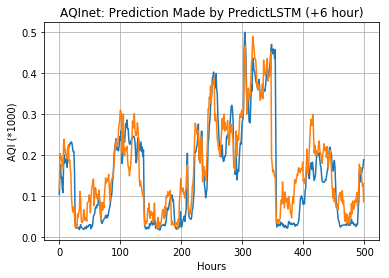

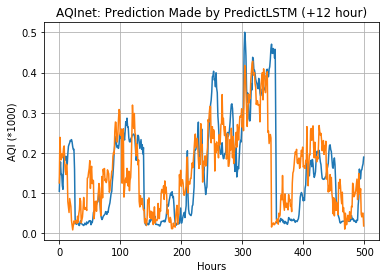

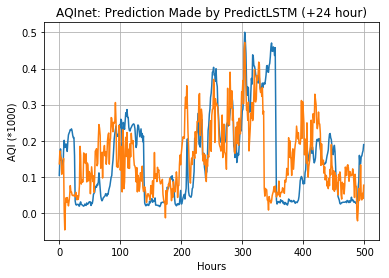

In [16]:
testPredictLSTM2 = LSTMmodel2.predict(testCurrent,batch_size=24)
start = 3000
end = 4500

#6 hour
dataTrainTrunk = testPredictLSTM2[start:end,5]
dataSetAQI = []
for elem in dataSet:
    dataSetAQI.append(elem[1])
dataBeforeTrunk = dataSetAQI[trainDataSize+start:trainDataSize+end]


plt.title('AQInet: Prediction Made by PredictLSTM (+6 hour)')
# plt.legend(['A simple line'])
plt.plot(dataBeforeTrunk)
plt.plot(dataTrainTrunk)
plt.grid(True)
plt.ylabel('AQI (*1000)')
plt.xlabel('Hours')
plt.savefig('6hour_L6_2.png',dpi=1000)
plt.show()

#12 hour
dataTrainTrunk = testPredictLSTM2[start:end,11]
dataSetAQI = []
for elem in dataSet:
    dataSetAQI.append(elem[1])
dataBeforeTrunk = dataSetAQI[trainDataSize+start:trainDataSize+end]


plt.title('AQInet: Prediction Made by PredictLSTM (+12 hour)')
# plt.legend(['A simple line'])
plt.plot(dataBeforeTrunk)
plt.plot(dataTrainTrunk)
plt.grid(True)
plt.ylabel('AQI (*1000)')
plt.xlabel('Hours')
plt.savefig('12hour_L6_2.png',dpi=1000)
plt.show()


#24 hour

dataTrainTrunk = testPredictLSTM2[start:end,23]
dataSetAQI = []
for elem in dataSet:
    dataSetAQI.append(elem[1])
dataBeforeTrunk = dataSetAQI[trainDataSize+start:trainDataSize+end]


plt.title('AQInet: Prediction Made by PredictLSTM (+24 hour)')
# plt.legend(['A simple line'])
plt.plot(dataBeforeTrunk)
plt.plot(dataTrainTrunk)
plt.grid(True)
plt.ylabel('AQI (*1000)')
plt.xlabel('Hours')
plt.savefig('24hour_L6_2.png',dpi=1000)
plt.show()


# 模型构造：多层. Model Construction: Multiple Layer

### 输入层. Input Layer
** 23 inputs **
### 隐藏层. Hidden Layer
** 100 LSTM Units, Not Stateful **
** 100 LSTM Units, Not Stateful **

### 输出层. Output Layer
** Dense 24 units **


### 模型拟合. Model fitting
** Adam Optimizer ** 
** 10 Epochs **
** Batch Size: 24 **

In [17]:
# 创建大型 LSTM 网络
LSTMmodel3 = Sequential()
LSTMmodel3.add(LSTM(100, input_shape=(1, 23),return_sequences=True))
LSTMmodel3.add(LSTM(100))
LSTMmodel3.add(Dense(24))
LSTMmodel3.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
historyLarge = LSTMmodel3.fit(trainCurrent, trainFutureAQI, epochs=10, batch_size=24, verbose=2)

Epoch 1/10
15s - loss: 0.0035 - mean_absolute_error: 0.0395 - acc: 0.1290
Epoch 2/10
11s - loss: 0.0028 - mean_absolute_error: 0.0346 - acc: 0.1460
Epoch 3/10
11s - loss: 0.0027 - mean_absolute_error: 0.0338 - acc: 0.1500
Epoch 4/10
11s - loss: 0.0027 - mean_absolute_error: 0.0334 - acc: 0.1522
Epoch 5/10
11s - loss: 0.0027 - mean_absolute_error: 0.0331 - acc: 0.1556
Epoch 6/10
12s - loss: 0.0026 - mean_absolute_error: 0.0327 - acc: 0.1586
Epoch 7/10
13s - loss: 0.0026 - mean_absolute_error: 0.0324 - acc: 0.1592
Epoch 8/10
13s - loss: 0.0026 - mean_absolute_error: 0.0322 - acc: 0.1581
Epoch 9/10
11s - loss: 0.0025 - mean_absolute_error: 0.0320 - acc: 0.1627
Epoch 10/10
11s - loss: 0.0025 - mean_absolute_error: 0.0318 - acc: 0.1625


In [18]:
scoresLarge = LSTMmodel3.evaluate(testCurrent, testFutureAQI, verbose=0)
print("%s: %.5f" % (LSTMmodel3.metrics_names[0], scoresLarge[0]))
print("%s: %.2f%%" % (LSTMmodel3.metrics_names[1], scoresLarge[1]*1000))
print("%s: %.2f%%" % (LSTMmodel3.metrics_names[2], scoresLarge[2]*100))
print(LSTMmodel3.summary())
LSTMmodel3.save("AQINet_lesson6_Deep.h5")

loss: 0.00241
mean_absolute_error: 31.00%
acc: 17.23%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 100)            49600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 24)                2424      
Total params: 132,424.0
Trainable params: 132,424
Non-trainable params: 0.0
_________________________________________________________________
None


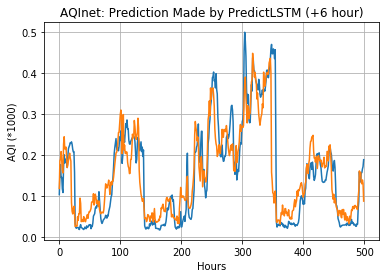

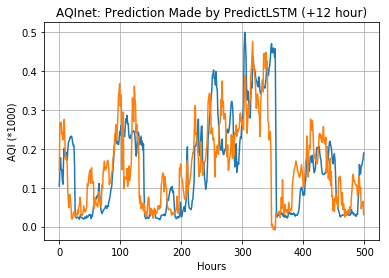

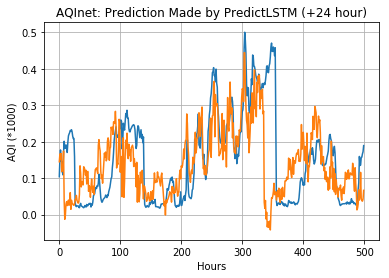

In [19]:
testPredictLSTM3 = LSTMmodel3.predict(testCurrent)

start = 4000
end = 4500

#6 hour
dataTrainTrunk = testPredictLSTM3[start:end,5]
dataSetAQI = []
for elem in dataSet:
    dataSetAQI.append(elem[1])
dataBeforeTrunk = dataSetAQI[trainDataSize+start:trainDataSize+end]


plt.title('AQInet: Prediction Made by PredictLSTM (+6 hour)')
# plt.legend(['A simple line'])
plt.plot(dataBeforeTrunk)
plt.plot(dataTrainTrunk)
plt.grid(True)
plt.ylabel('AQI (*1000)')
plt.xlabel('Hours')
plt.savefig('6hour_L6_3.png',dpi=1000)
plt.show()

#12 hour
dataTrainTrunk = testPredictLSTM3[start:end,11]
dataSetAQI = []
for elem in dataSet:
    dataSetAQI.append(elem[1])
dataBeforeTrunk = dataSetAQI[trainDataSize+start:trainDataSize+end]


plt.title('AQInet: Prediction Made by PredictLSTM (+12 hour)')
# plt.legend(['A simple line'])
plt.plot(dataBeforeTrunk)
plt.plot(dataTrainTrunk)
plt.grid(True)
plt.ylabel('AQI (*1000)')
plt.xlabel('Hours')
plt.savefig('12hour_L6_3.png',dpi=1000)
plt.show()


#24 hour

dataTrainTrunk = testPredictLSTM3[start:end,23]
dataSetAQI = []
for elem in dataSet:
    dataSetAQI.append(elem[1])
dataBeforeTrunk = dataSetAQI[trainDataSize+start:trainDataSize+end]


plt.title('AQInet: Prediction Made by PredictLSTM (+24 hour)')
# plt.legend(['A simple line'])
plt.plot(dataBeforeTrunk)
plt.plot(dataTrainTrunk)
plt.grid(True)
plt.ylabel('AQI (*1000)')
plt.xlabel('Hours')
plt.savefig('24hour_L6_3.png',dpi=1000)
plt.show()


# 模型构造：Dropout. Model Construction: Dropout

### 输入层. Input Layer
** 23 inputs **
### 隐藏层. Hidden Layer
** 200 LSTM Units, Not Stateful **
** Dropout_U = .2 **
** Dropout_W = .2 **

### 输出层. Output Layer
** Dense 24 units **


### 模型拟合. Model fitting
** Adam Optimizer **
** 10 Epochs **
** Batch Size: 24 **

In [21]:
# 创建大型 LSTM 网络
LSTMmodel4 = Sequential()
LSTMmodel4.add(LSTM(200, input_shape=(1,23), dropout_U=0.2, dropout_W=0.2))
LSTMmodel4.add(Dense(24))
LSTMmodel4.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
history4 = LSTMmodel4.fit(trainCurrent, trainFutureAQI, epochs=10, batch_size=24, verbose=2)

C:\Users\Christopher\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, input_shape=(1, 23), recurrent_dropout=0.2, dropout=0.2)`
  app.launch_new_instance()


Epoch 1/10
15s - loss: 0.0045 - mean_absolute_error: 0.0465 - acc: 0.1083
Epoch 2/10
14s - loss: 0.0038 - mean_absolute_error: 0.0419 - acc: 0.1226
Epoch 3/10
14s - loss: 0.0036 - mean_absolute_error: 0.0409 - acc: 0.1307
Epoch 4/10
14s - loss: 0.0036 - mean_absolute_error: 0.0403 - acc: 0.1347
Epoch 5/10
15s - loss: 0.0035 - mean_absolute_error: 0.0397 - acc: 0.1351
Epoch 6/10
15s - loss: 0.0034 - mean_absolute_error: 0.0394 - acc: 0.1382
Epoch 7/10
15s - loss: 0.0034 - mean_absolute_error: 0.0392 - acc: 0.1392
Epoch 8/10
14s - loss: 0.0034 - mean_absolute_error: 0.0388 - acc: 0.1414
Epoch 9/10
14s - loss: 0.0033 - mean_absolute_error: 0.0382 - acc: 0.1417
Epoch 10/10
12s - loss: 0.0032 - mean_absolute_error: 0.0380 - acc: 0.1434


In [22]:
scores4 = LSTMmodel4.evaluate(testCurrent, testFutureAQI, verbose=0)
print("%s: %.5f" % (LSTMmodel4.metrics_names[0], scores4[0]))
print("%s: %.2f%%" % (LSTMmodel4.metrics_names[1], scores4[1]*1000))
print("%s: %.2f%%" % (LSTMmodel4.metrics_names[2], scores4[2]*100))
print(LSTMmodel4.summary())
LSTMmodel4.save("LSTM_3_E18_5_7.h5")

loss: 0.00261
mean_absolute_error: 32.74%
acc: 13.40%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 200)               179200    
_________________________________________________________________
dense_5 (Dense)              (None, 24)                4824      
Total params: 184,024.0
Trainable params: 184,024
Non-trainable params: 0.0
_________________________________________________________________
None


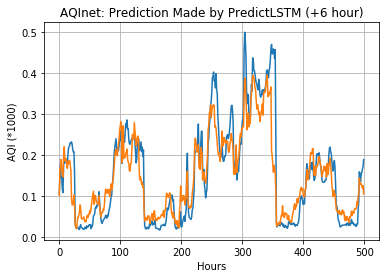

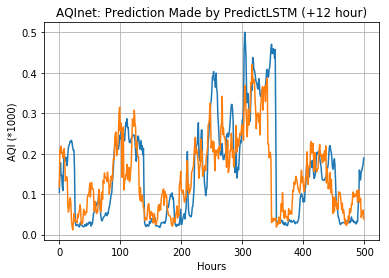

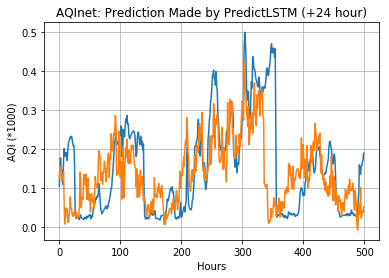

In [23]:
testPredictLSTM4 = LSTMmodel4.predict(testCurrent)

start = 4000
end = 4500

#6 hour
dataTrainTrunk = testPredictLSTM4[start:end,5]
dataSetAQI = []
for elem in dataSet:
    dataSetAQI.append(elem[1])
dataBeforeTrunk = dataSetAQI[trainDataSize+start:trainDataSize+end]


plt.title('AQInet: Prediction Made by PredictLSTM (+6 hour)')
# plt.legend(['A simple line'])
plt.plot(dataBeforeTrunk)
plt.plot(dataTrainTrunk)
plt.grid(True)
plt.ylabel('AQI (*1000)')
plt.xlabel('Hours')
plt.savefig('6hour_L6_4.png',dpi=1000)
plt.show()

#12 hour
dataTrainTrunk = testPredictLSTM4[start:end,11]
dataSetAQI = []
for elem in dataSet:
    dataSetAQI.append(elem[1])
dataBeforeTrunk = dataSetAQI[trainDataSize+start:trainDataSize+end]


plt.title('AQInet: Prediction Made by PredictLSTM (+12 hour)')
# plt.legend(['A simple line'])
plt.plot(dataBeforeTrunk)
plt.plot(dataTrainTrunk)
plt.grid(True)
plt.ylabel('AQI (*1000)')
plt.xlabel('Hours')
plt.savefig('12hour_L6_4.png',dpi=1000)
plt.show()


#24 hour

dataTrainTrunk = testPredictLSTM4[start:end,23]
dataSetAQI = []
for elem in dataSet:
    dataSetAQI.append(elem[1])
dataBeforeTrunk = dataSetAQI[trainDataSize+start:trainDataSize+end]


plt.title('AQInet: Prediction Made by PredictLSTM (+24 hour)')
# plt.legend(['A simple line'])
plt.plot(dataBeforeTrunk)
plt.plot(dataTrainTrunk)
plt.grid(True)
plt.ylabel('AQI (*1000)')
plt.xlabel('Hours')
plt.savefig('24hour_L6_4.png',dpi=1000)
plt.show()


# 可视化预测. Visualing the the predictions

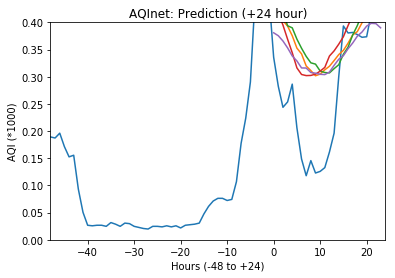

In [24]:
plt.clf()
xa = np.arange(-48,24)
xp = np.arange(-24, 0)
start = 4000
end = 4500
for i in range(500):
#     pl.plot(i,dataBeforeTrunk[i], )
#     testCurrent[i:i+10,0,4]
    plt.title('AQInet: Prediction (+24 hour)')
    plt.ylabel('AQI (*1000)')
    plt.xlabel('Hours (-48 to +24)')
    plt.plot(xa,testCurrent[i+start:i+(start+72),0,1], linestyle='solid')
    plt.plot(testPredictLSTM1[i+(start+47)], linestyle='solid')
    plt.plot(testPredictLSTM2[i+(start+47)], linestyle='solid')
    plt.plot(testPredictLSTM3[i+(start+47)], linestyle='solid')
    plt.plot(testPredictLSTM4[i+(start+47)], linestyle='solid')
#     plt.plot([sum(e)/len(e) for e in zip(*data)])
#     plt.plot(xp,testPredictLSTM_large[i+46], linestyle='solid')
#     plt.plot(xp,testPredictLSTM_small[i+46], linestyle='solid')
#     plt.plot(xp,testPredictLSTM[i+46], linestyle='solid')
#     plt.plot(xp,testPredictLSTM_deep[i+46], linestyle='solid')
#     plt.plot(xp,testPredictLSTM_multilevel[i+46], linestyle='solid')
    plt.axis([-48, 24, 0,max(testCurrent[i:i+48,0,4]+.2)])
    plotname = "Prediction Movie(E18)/plot" + str(i+100) + ".png"
    plt.savefig(plotname,dpi=100)
    time.sleep(.01)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    
plt.clf()